# more prolif sandboxing

In [1]:
import prolif as plf
import numpy as np
import analysis_functions
import pandas as pd


import networkx as nx
from pyvis.network import Network
from matplotlib import cm, colors
from IPython.display import IFrame

In [2]:
all_unis, all_lens = analysis_functions.load_em_unis()

In [3]:
u = all_unis['PfHT_MMV12'][0]
lig = u.select_atoms('resname MMV')
prot = u.select_atoms('protein')

In [4]:
all_fp_dfs = {}
skip = 1

for condition in all_unis.keys():
    # print(condition)
    temp_fp_dfs = []
    for n, rep_fp in enumerate(all_unis[condition]):
        if (
            condition != "PfHT_apo"
        ):  ## no need to run fingerprints on sim that doesn't have mmv...
            df = analysis_functions.get_fp_dataframe(
                u=rep_fp,
                skip=skip,
                run_calc=False,
                filename=f"{condition}.replica_{n+1}.skip{skip}",
            )
            temp_fp_dfs.append(df)
    all_fp_dfs[condition] = temp_fp_dfs
all_fp_dfs.pop("PfHT_apo")  ## probably a better way to remove this guy, but that's ok

[]

In [6]:
def make_graph(
    values,
    df=None,
    node_color=["#FFB2AC", "#ACD0FF"],
    node_shape="dot",
    edge_color="#a9a9a9",
    width_multiplier=1,
):
    """Convert a pandas DataFrame to a NetworkX object

    Parameters
    ----------
    values : pandas.Series
        Series with 'ligand' and 'protein' levels, and a unique value for
        each lig-prot residue pair that will be used to set the width and weigth
        of each edge. For example:

            ligand  protein
            LIG1.G  ALA216.A    0.66
                    ALA343.B    0.10

    df : pandas.DataFrame
        DataFrame obtained from the fp.to_dataframe() method
        Used to label each edge with the type of interaction

    node_color : list
        Colors for the ligand and protein residues, respectively

    node_shape : str
        One of ellipse, circle, database, box, text or image, circularImage,
        diamond, dot, star, triangle, triangleDown, square, icon.

    edge_color : str
        Color of the edge between nodes

    width_multiplier : int or float
        Each edge's width is defined as `width_multiplier * value`
    """
    lig_res = values.index.get_level_values("ligand").unique().tolist()
    prot_res = values.index.get_level_values("protein").unique().tolist()

    G = nx.Graph()
    # add nodes
    # https://pyvis.readthedocs.io/en/latest/documentation.html#pyvis.network.Network.add_node
    for res in lig_res:
        G.add_node(
            res, title=res, shape=node_shape, color=node_color[0], dtype="ligand"
        )
    for res in prot_res:
        G.add_node(
            res, title=res, shape=node_shape, color=node_color[1], dtype="protein"
        )

    for resids, value in values.items():
        label = "{} - {}<br>{}".format(
            *resids,
            "<br>".join(
                [
                    f"{k}: {v}"
                    for k, v in (
                        df.xs(resids, level=["ligand", "protein"], axis=1)
                        .sum()
                        .to_dict()
                        .items()
                    )
                ]
            ),
        )
        # https://pyvis.readthedocs.io/en/latest/documentation.html#pyvis.network.Network.add_edge
        G.add_edge(
            *resids,
            title=label,
            color=edge_color,
            weight=value,
            width=value * width_multiplier,
        )

    return G

In [7]:
import matplotlib.pyplot as plt

In [8]:
df = all_fp_dfs["PfHT_MMV12"][0]
df = pd.concat([df], keys=['MMV'], names=['ligand'],axis=1)

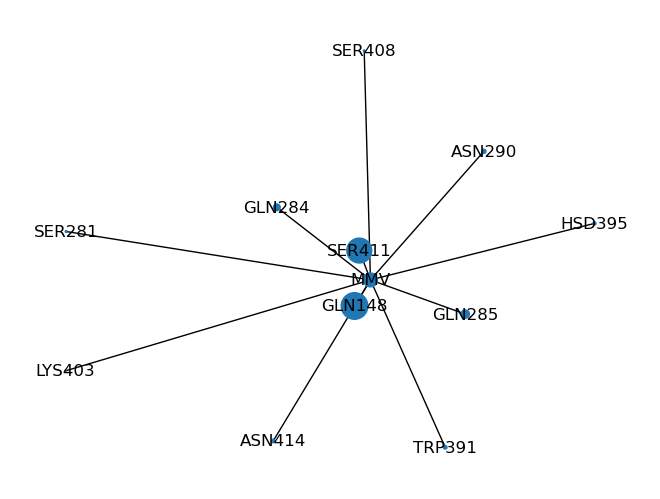

In [66]:
data = df.xs("HBAcceptor", level="interaction", axis=1).mean()

G = make_graph(data, df, width_multiplier=3)


weights = {}
for n,edge in enumerate(G.edges):
    weights[edge[1]] = list(G.edges(data=True))[n][2]['weight']

node_sizes = [100]
node_sizes.extend(np.array(list(weights.values()))*400)
# display graph
net = Network(width=600, height=500, notebook=True, heading="")
nx.draw(G, with_labels=True, node_size=node_sizes)





### for HTML viz
#net.from_nx(G)
#net.write_html("lig-prot_hydrophobic_graph.html")
#IFrame("lig-prot_hydrophobic_graph.html", width=610, height=510, cdn_resources='remote')

[4, 3]

In [36]:
weights

{'GLN148': 0.9180819180819181,
 'SER281': 0.003996003996003996,
 'GLN284': 0.058941058941058944,
 'GLN285': 0.0899100899100899,
 'ASN290': 0.02197802197802198,
 'TRP391': 0.015984015984015984,
 'HSD395': 0.011988011988011988,
 'LYS403': 0.002997002997002997,
 'SER408': 0.002997002997002997,
 'SER411': 0.8011988011988012,
 'ASN414': 0.015984015984015984}

In [25]:
from prolif.plotting.network import LigNetwork

lmol = plf.Molecule.from_mda(lig)


In [31]:
LigNetwork(df=df2, lig_mol=lmol,)

KeyError: 'Requested level (interaction) does not match index name (Frame)'

In [30]:
df2 = df.droplevel("ligand", axis=1)


In [33]:
help(LigNetwork)

Help on class LigNetwork in module prolif.plotting.network:

class LigNetwork(builtins.object)
 |  LigNetwork(df, lig_mol, match3D=True, kekulize=False, molsize=35, rotation=0, carbon=0.16)
 |  
 |  Creates a ligand interaction diagram
 |  
 |  Parameters
 |  ----------
 |  df : pandas.DataFrame
 |      Dataframe with a 4-level index (ligand, protein, interaction, atom)
 |      and a weight column for values
 |  lig_mol : rdkit.Chem.rdChem.Mol
 |      Ligand molecule
 |  match3D : bool
 |      If ``True``, generates 2D coordines that are constrained to fit the
 |      3D conformation of the ligand as best as possible. Else, generate 2D
 |      coordinates from scratch
 |  kekulize : bool
 |      Kekulize the ligand
 |  molsize : int
 |      Multiply the coordinates by this number to create a bigger and
 |      more readable depiction
 |  rotation : int
 |      Rotate the structure on the XY plane
 |  carbon : float
 |      Size of the carbon atom dots on the depiction. Use `0` to hide 

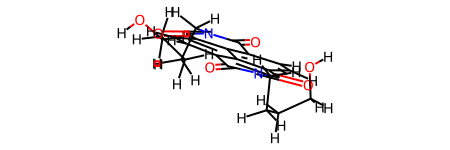

In [35]:
lmol